# Aufenthaltsdauer in Zuständen aus Rohdaten

### Zustände

* Zuhause -> 1
* Arbeit -> 2 
* Einkaufen -> 3 
* Freizeit -> 4
* Sonstiges -> 5

In [1]:
import pandas as pd
import numpy as np 
import matplotlib as mlp
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
# einlesen des bearbeiteten Trips-Datensatz
df = pd.read_csv(r"C:\Users\thoma\Desktop\ev-modelling-repo\Rohdaten\NHTS_trips_processed.csv")

## Ermitteln des Aufenthalts in Zielzuständen der Trips

In [3]:
# hinzufügen einer Spalte zum Eintragen der Aufenthaltsdauern
df["Stay_duration"] = 0
df.head()

,ID,Type_day,TRPTRANS,Trip_no,Whyfrom,Whyto,Distance,Trip_duration,Departure_hhmm,Arrival_hhmm,Departure,Arrival,Departure_t,Stay_duration
0,300000071,1,3,1,1,4,8.439,15,1000,1015,600,615,40,0
1,300000071,1,3,2,4,1,8.286,20,1510,1530,910,930,61,0
2,300000072,1,6,1,2,1,135.191,120,700,900,420,540,28,0
3,300000072,1,6,2,1,2,131.367,150,1800,2030,1080,1230,72,0
4,300000073,1,3,1,1,2,3.621,15,845,900,525,540,35,0


### Auf Wochentage filtern

In [4]:
filt = df["Type_day"] < 6
df = df[filt]

## Sortieren des DataFrames zunächst nach ID und dann nach Wegnummer
-> so befinden sich alle Trips derselben Person in aufsteigender Reihenfolge hintereinander

In [5]:
df = df.sort_values(by=['ID', 'Trip_no'])

In [6]:
# reihenweise Indizierung nach Umsortierung wiederherstellen
df.reset_index(inplace=True, drop=True)
df.tail()

,ID,Type_day,TRPTRANS,Trip_no,Whyfrom,Whyto,Distance,Trip_duration,Departure_hhmm,Arrival_hhmm,Departure,Arrival,Departure_t,Stay_duration
633016,4045582510,3,6,4,5,5,4.310,7,753,800,473,480,32,0
633017,4045582510,3,6,5,5,3,3.421,17,803,820,483,500,32,0
633018,4045582510,3,6,6,3,1,11.676,40,920,1000,560,600,37,0
633019,4045582510,3,6,7,1,2,55.371,40,1520,1600,920,960,61,0
633020,4045582510,3,6,8,2,1,56.403,30,2300,2330,1380,1410,92,0


## Berechnen der Aufenthalte in den Zuständen 

In [7]:
# Auswertung Reihe für Reihe, Zuordnung der Trips über ID
def calc_aufenthalt(df):
    rows = df.shape[0]
    for i in range(rows):
        # letzter Trip der Person -> Aufenthalt = Zeit bis zum ersten Trip 
        if (i == rows-1) or (df.at[i+1, "ID"] != df.at[i, "ID"]):
            # Beispiel: Wenn Wegnummer = 3 liegt Index des ersten Wegs 2 Schritte zurück
            index_first_trip = i - (df.at[i, "Trip_no"] - 1) 
            start_first_trip = df.at[index_first_trip, "Departure"]
            end_trip = df.at[i,"Arrival"]
            # Gesamtaufenthalt = 
            # Rest des Tages + Zeit bis zum ersten Trip
            if end_trip > start_first_trip:           
                df.at[i, "Stay_duration"] = 1440 - end_trip + start_first_trip
            # Wenn letzte Fahrt nach 24:00
            elif end_trip < start_first_trip:
                df.at[i, "Stay_duration"] = start_first_trip - end_trip
        else:
            end_trip = df.at[i, "Arrival"]
            start_next_trip = df.at[i+1, "Departure"]
            aufenthalt = start_next_trip - end_trip
            # wenn Aufenthalt < 0 ist nächster Trip nach 24:00 
            if aufenthalt < 0:
                aufenthalt = (1440 - end_trip) + start_next_trip
            df.at[i, "Stay_duration"] = aufenthalt

In [8]:
calc_aufenthalt(df)

In [9]:
df.head()

,ID,Type_day,TRPTRANS,Trip_no,Whyfrom,Whyto,Distance,Trip_duration,Departure_hhmm,Arrival_hhmm,Departure,Arrival,Departure_t,Stay_duration
0,300000071,1,3,1,1,4,8.439,15,1000,1015,600,615,40,295
1,300000071,1,3,2,4,1,8.286,20,1510,1530,910,930,61,1110
2,300000072,1,6,1,2,1,135.191,120,700,900,420,540,28,540
3,300000072,1,6,2,1,2,131.367,150,1800,2030,1080,1230,72,630
4,300000073,1,3,1,1,2,3.621,15,845,900,525,540,35,330


## Abspeichern der Daten mit errechnetem Aufenthaltszeiten

In [10]:
df.to_csv(r'C:\Users\thoma\Desktop\ev-modelling-repo\Rohdaten\NHTS_trips_processed_WT_Aufenthalt.csv', header=True, index=False) 

## Zuweisung der Aufenthalte in den unterschiedlichen Zuständen zu entsprechenden Variablen

In [11]:
filt = df["Whyto"] == 1
aufenthalt_zuhause = df[filt]["Stay_duration"]
filt = df["Whyto"] == 2
aufenthalt_arbeit = df[filt]["Stay_duration"]
filt = df["Whyto"] == 3
aufenthalt_einkaufen = df[filt]["Stay_duration"]
filt = df["Whyto"] == 4
aufenthalt_freizeit = df[filt]["Stay_duration"]
filt = df["Whyto"] == 5
aufenthalt_sonstiges = df[filt]["Stay_duration"]

## Plotten der Histogramme der Aufenthaltsdauern

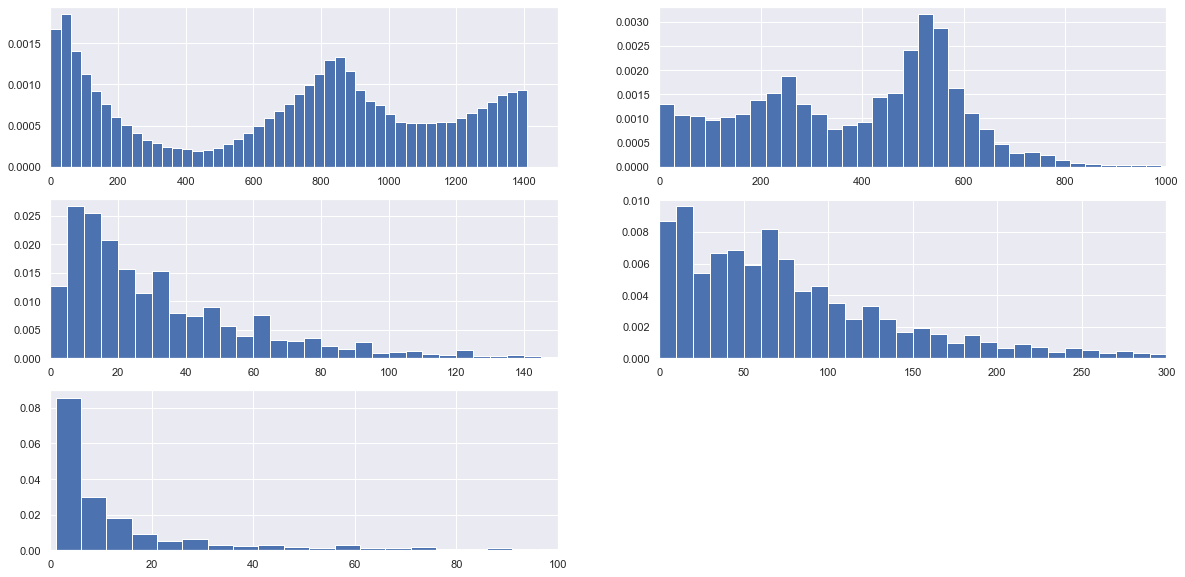

In [12]:
sns.set()
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(20,10))
ax1.hist(aufenthalt_zuhause, bins=range(int(min(aufenthalt_zuhause)), int(max(aufenthalt_zuhause)), 30), density=True);
ax1.set_xlim([0, 1500])
ax2.hist(aufenthalt_arbeit, bins=range(int(min(aufenthalt_arbeit)), int(max(aufenthalt_arbeit)), 30), density=True);
ax2.set_xlim([0,1000])
ax3.hist(aufenthalt_einkaufen, bins=range(int(min(aufenthalt_einkaufen)), int(max(aufenthalt_einkaufen)), 5), density=True);
ax3.set_xlim([0,150])
ax4.hist(aufenthalt_freizeit, bins=range(int(min(aufenthalt_freizeit)), int(max(aufenthalt_freizeit)), 10), density=True);
ax4.set_xlim([0,300])
ax5.hist(aufenthalt_sonstiges, bins=range(int(min(aufenthalt_sonstiges)), int(max(aufenthalt_sonstiges)), 5), density=True);
ax5.set_xlim([0,100])
fig.delaxes(ax6)

## Ermitteln Verteilungsfunktion über Density Estimation Modell

### Randnotiz
Das die Density Estimation Modelle in den negativen x-Bereich reichen ist mir ursprünglich nicht aufgefallen, da ich cleverer Fuchs das x-Achsen Limit der Darstellung zunächst bei 0 hatte. 


In der Simulation bin ich das Problem vorerst umgangen indem ich bei negativen Werten einfach ein neues Sample ziehe. Hier kann man sich überlegen ob man das noch besser lösen kann, da ich auf diesem Wege vermutlich die Aufenthatlsdauern etwas noch oben verzerre.

In [13]:
from sklearn.neighbors import KernelDensity

## Erstellen Kernel Density Estimation Modell Zuhause 

In [14]:
kde_model_zuhause = KernelDensity(bandwidth=25)
kde_model_zuhause.fit(aufenthalt_zuhause[:, np.newaxis])
# übertragen in visaulisierbare Wahrscheinlichkeitsdichtefunktion
x = np.linspace(-50, max(aufenthalt_zuhause), 1000)
log_pdf = kde_model_zuhause.score_samples(x[:, np.newaxis])
kde_zuhause_pdf = np.exp(log_pdf)

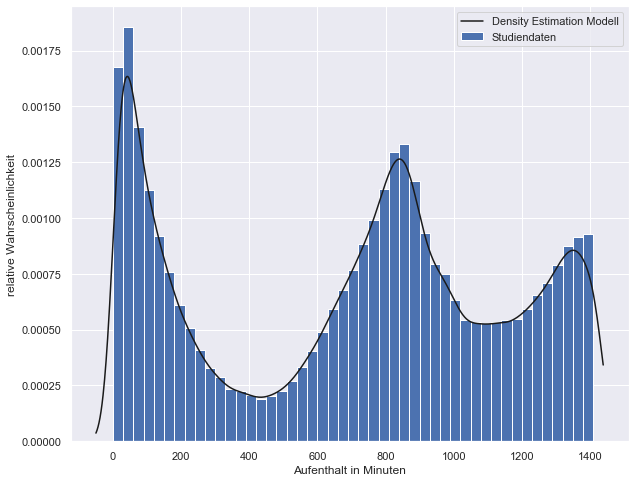

In [15]:
plt.figure(figsize=(10,8))
plt.hist(aufenthalt_zuhause, bins=range(int(min(aufenthalt_zuhause)), int(max(aufenthalt_zuhause)), 30), density=True);
plt.plot(x, kde_zuhause_pdf, '-k');
labels = ["Density Estimation Modell", "Studiendaten"]
plt.legend(labels);
plt.xlabel("Aufenthalt in Minuten");
plt.ylabel("relative Wahrscheinlichkeit");

## Erstellen Kernel Density Estimation Modell Arbeit

In [16]:
kde_model_arbeit = KernelDensity(bandwidth=18)
kde_model_arbeit.fit(aufenthalt_arbeit[:, np.newaxis])
# übertragen in visaulisierbare Wahrscheinlichkeitsdichtefunktion
x = np.linspace(-50, max(aufenthalt_arbeit), 1000)
log_pdf = kde_model_arbeit.score_samples(x[:, np.newaxis])
kde_arbeit_pdf = np.exp(log_pdf)

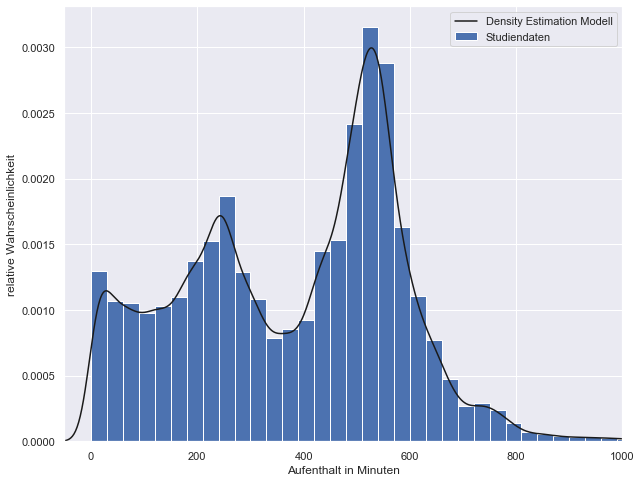

In [17]:
plt.figure(figsize=(10,8))
plt.hist(aufenthalt_arbeit, bins=range(int(min(aufenthalt_arbeit)), int(max(aufenthalt_arbeit)), 30), density=True);
plt.plot(x, kde_arbeit_pdf, '-k');
labels = ["Density Estimation Modell", "Studiendaten"]
plt.legend(labels);
plt.gca().set_xlim(-50, 1000)
plt.xlabel("Aufenthalt in Minuten");
plt.ylabel("relative Wahrscheinlichkeit");

## Erstellen Kernel Density Estimation Modell Einkaufen

In [18]:
kde_model_einkaufen = KernelDensity(bandwidth=8)
kde_model_einkaufen.fit(aufenthalt_einkaufen[:, np.newaxis])
# übertragen in visaulisierbare Wahrscheinlichkeitsdichtefunktion
x = np.linspace(-50, max(aufenthalt_einkaufen), 1000)
log_pdf = kde_model_einkaufen.score_samples(x[:, np.newaxis])
kde_einkaufen_pdf = np.exp(log_pdf)

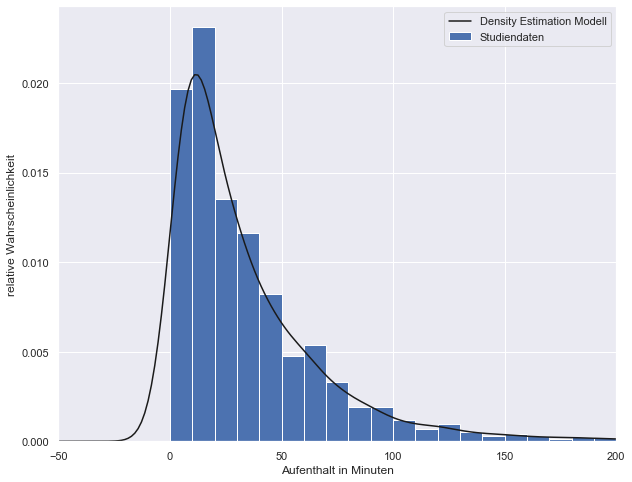

In [19]:
plt.figure(figsize=(10,8))
plt.hist(aufenthalt_einkaufen, bins=range(int(min(aufenthalt_einkaufen)), int(max(aufenthalt_einkaufen)), 10), density=True);
plt.plot(x, kde_einkaufen_pdf, '-k');
labels = ["Density Estimation Modell", "Studiendaten"]
plt.legend(labels);
plt.gca().set_xlim(-50, 200)
plt.xlabel("Aufenthalt in Minuten");
plt.ylabel("relative Wahrscheinlichkeit");

## Erstellen Kernel Density Estimation Modell Freizeit

In [20]:
kde_model_freizeit = KernelDensity(bandwidth=8)
kde_model_freizeit.fit(aufenthalt_freizeit[:, np.newaxis])
# übertragen in visaulisierbare Wahrscheinlichkeitsdichtefunktion
x = np.linspace(-50, max(aufenthalt_freizeit), 1000)
log_pdf = kde_model_freizeit.score_samples(x[:, np.newaxis])
kde_freizeit_pdf = np.exp(log_pdf)

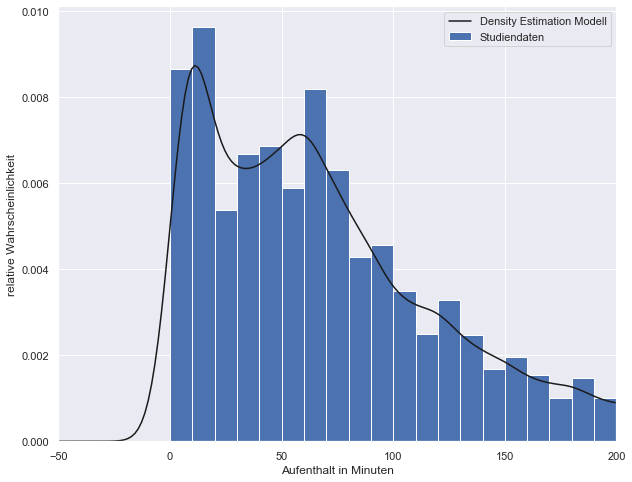

In [21]:
plt.figure(figsize=(10,8))
plt.hist(aufenthalt_freizeit, bins=range(int(min(aufenthalt_freizeit)), int(max(aufenthalt_freizeit)), 10), density=True);
plt.plot(x, kde_freizeit_pdf, '-k');
labels = ["Density Estimation Modell", "Studiendaten"]
plt.legend(labels);
plt.gca().set_xlim(-50, 200)
plt.xlabel("Aufenthalt in Minuten");
plt.ylabel("relative Wahrscheinlichkeit");

## Erstellen Kernel Density Estimation Modell Sonstiges

In [22]:
kde_model_sonstiges = KernelDensity(bandwidth=2)
kde_model_sonstiges.fit(aufenthalt_sonstiges[:, np.newaxis])
# übertragen in visaulisierbare Wahrscheinlichkeitsdichtefunktion
x = np.linspace(-50, max(aufenthalt_sonstiges), 1000)
log_pdf = kde_model_sonstiges.score_samples(x[:, np.newaxis])
kde_sonstiges_pdf = np.exp(log_pdf)

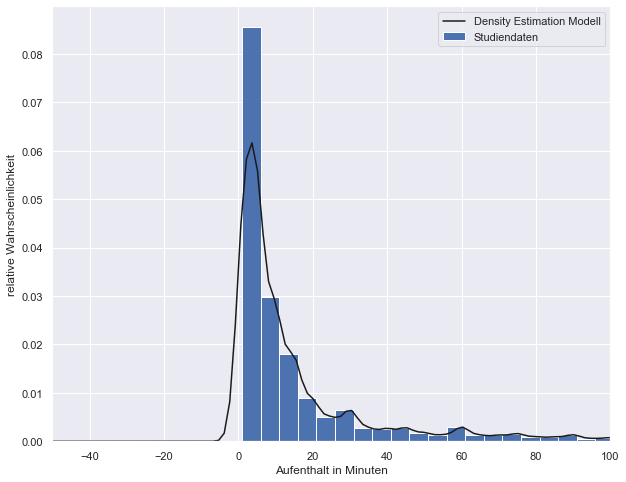

In [23]:
plt.figure(figsize=(10,8))
plt.hist(aufenthalt_sonstiges, bins=range(int(min(aufenthalt_sonstiges)), int(max(aufenthalt_sonstiges)), 5), density=True);
plt.plot(x, kde_sonstiges_pdf, '-k');
labels = ["Density Estimation Modell", "Studiendaten"]
plt.legend(labels);
plt.gca().set_xlim(-50, 100)
plt.xlabel("Aufenthalt in Minuten");
plt.ylabel("relative Wahrscheinlichkeit");

## Lognormalverteilung Sonstiges

Scheint 

In [24]:
x = np.linspace(0, max(aufenthalt_sonstiges), 1000)
shape_sonstiges, loc_sonstiges, scale_sonstiges = stats.lognorm.fit(aufenthalt_sonstiges, floc=0)
pdf_sonstiges = stats.lognorm.pdf(x, s=shape_sonstiges, loc=loc_sonstiges, scale=scale_sonstiges)

(-50, 100)

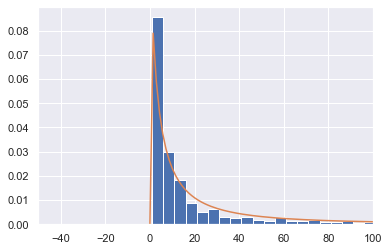

In [25]:
plt.figure()
plt.hist(aufenthalt_sonstiges, bins=range(int(min(aufenthalt_sonstiges)), int(max(aufenthalt_sonstiges)), 5), density=True);
plt.plot(x, pdf_sonstiges)
plt.gca().set_xlim(-50, 100)

## Gamma - Verteilung verwenden 

In [26]:
x = np.linspace(0, max(aufenthalt_sonstiges), 1000)
alpha_sonstiges_g, loc_sonstiges_g, scale_sonstiges_g = stats.gamma.fit(aufenthalt_sonstiges, floc=0)
pdf_g_sonstiges = stats.gamma.pdf(x, a=alpha_sonstiges_g, loc=loc_sonstiges_g, scale=scale_sonstiges_g)

(-50, 100)

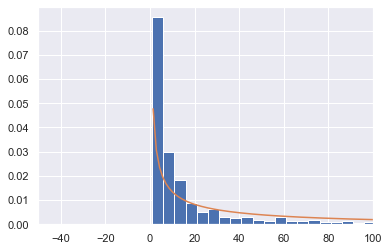

In [27]:
plt.figure()
plt.hist(aufenthalt_sonstiges, bins=range(int(min(aufenthalt_sonstiges)), int(max(aufenthalt_sonstiges)), 5), density=True);
plt.plot(x, pdf_g_sonstiges)
plt.gca().set_xlim(-50, 100)

## Modelle und Histogramme speichern

In [28]:
from pathlib import Path
import pickle
import os

root = os.getcwd()
if not os.path.exists(os.getcwd()+ "\\Simulationsdaten"):
    os.makedirs(root+"\\Simulationsdaten")

# Modelle in Liste zusammenfassen
models = [kde_model_zuhause, kde_model_arbeit, kde_model_einkaufen, kde_model_freizeit, kde_model_sonstiges]
# Histogramme werden in der Simulationsauswertung als Vergleich herangezogen 
histograms = [aufenthalt_zuhause, aufenthalt_arbeit, aufenthalt_einkaufen, aufenthalt_freizeit, aufenthalt_sonstiges]

path_models = root+"\\Simulationsdaten\\Modelle_Aufenthaltsdauer_Werktag.pickle"
pickle.dump(models, open(path_models, "wb"))

path_histograms = root+"\\Simulationsdaten\\Histogramme_Aufenthaltsdauer_Werktag.pickle"
pickle.dump(histograms, open(path_histograms, "wb"))
